DSC160 Data Science and the Arts - Twomey - Spring 2020 - [dsc160.roberttwomey.com](http://dsc160.roberttwomey.com)

In [1]:
# import used packages
from bs4 import BeautifulSoup
import os
import requests
import numpy as np
from skimage import io
from skimage.color import rgb2hsv
import pandas as pd

# Exercise 1: Reading Image Archives (Web-Scraping and Basic Features)

This exercise takes you through the a coarse image-feature based analysis of a famous Abstract Expressionist painter, [Mark Rothko](https://www.biography.com/artist/mark-rothko). Technically, you will build a full workflow from image retrieval from an online archive -> calculation of image features -> visualization of results. Finally, it asks you to reproduce a similar result using a small image data set of your choice. 

The exercise is broken down into two parts:
- [Part 1](#Part-1:-Plotting-Rothko). A replication of an analysis by the Software Studies Initiative/Lev Manovich of Mark Rothko's paintings. 
- [Part 2](#Part-2:-Extension). The second section asks you to extend this work, applying the same methods to analyze an image set (n <= 100) of your choosing. 

Once you have completed both parts, you will submit your completed notebook as a pdf to gradescope for grading.

## Part 1: Plotting Rothko
(30 pts total)

[Mark Rothko](https://www.biography.com/artist/mark-rothko) is a celebrated Abstract Expressionist painter known for his large color field abstractions. Some historians describe a progression towards darker, less colorful compositions over the course of his life. Here, we will recreating plots similar to the plots below from the Software Studies Initiative, showing a distribution of color and brightness within his body of work.

![Rothko and Mondrian in mean brightness vs. saturation Style Space](https://live.staticflickr.com/6070/6074400716_c809d2d7a3_c_d.jpg)
*Data: 128 paintings by Piet Mondrian (1905-1917); 123 paintings by Mark Rothko (1938-1953).
Mapping: The two image plots are placed side by side. In each plot: X-axis: brightness mean; Y-axis: saturation mean.*

From [Mondrian vs Rothko: footprints and evolution in style space](http://lab.softwarestudies.com/2011/06/mondrian-vs-rothko-footprints-and.html)

### 1A. Retrieving Data from a Visual Archive
(5 points)

First you need to retreive images of Rothko's paintings from an online cultural archive. WikiArt has 163 of Rothko's paintings: [https://www.wikiart.org/en/mark-rothko](https://www.wikiart.org/en/mark-rothko). We will retrieve all of these images and store them locally. 

You can model your code on our example notebook for scraping images from WikiArt: [../examples/scrape-wikiart.ipynb](../examples/scrape-wikiart.ipynb)

In [2]:
# your code here
# set up data paths and urls
DATA_DIR = '../data/'
ARTIST_URL = 'https://www.wikiart.org/en/{artist}/all-works/text-list'
PAINTING_URL = 'https://www.wikiart.org{painting_path}'

# check if the file path exists, if not then create the directory
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [3]:
# get the page from WikiArt
url_query = ARTIST_URL.format(artist='mark-rothko')
artist_page = requests.get(url_query)

# raise error if there is request error
try:
    artist_page.raise_for_status()
except requests.exceptions.HTTPError as e:
    print("Error trying to retrieve {}".format(artist_page.url))
    raise e

# get the info stored on the page by BS4
soup = BeautifulSoup(artist_page.text, 'lxml')

In [4]:
# create image storage directory
IMAGE_DIR = os.path.join(DATA_DIR, 'mark-rothko/images')
if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR)

In [5]:
painting_paths = []

# retreive all rows in painting-list
for li in soup.find_all('li', {'class': 'painting-list-text-row'}):

    # retrieve all links in the current row
    for link in li.find_all('a'):
        href = link.get('href')
        # store in dictionary
        painting_paths.append(href)

# check how many paintings retrieved for Mark Rothko
print(len(painting_paths))

163


In [6]:
# method for downloading and saving the paintings
def download_and_save(painting_url):
    r_painting_page = requests.get(painting_url)
    soup = BeautifulSoup(r_painting_page.text, 'lxml')
    for img in soup.find_all('img', {'class': 'ms-zoom-cursor'}):
        img_url = img['src']
        img_url = img_url.split('!')[0]
        filename = img_url.split('/')[-1]

        outfile = os.path.join(IMAGE_DIR, filename)                       
        if not os.path.exists(outfile):                        
            print("downloading {}: {}".format(filename, img_url))
            r = requests.get(img_url, outfile)
            with open(outfile, 'wb') as f:
                f.write(r.content)
        else:
            #print("skipping {}".format(filename))
            pass

In [7]:
# download all the paintings from Mark Rothko
for path in painting_paths:
    painting_path = PAINTING_URL.format(painting_path=path)
    download_and_save(painting_path)

In [8]:
# double-check with the number of downloaded images
len(os.listdir('../data/mark-rothko/images'))

163

### 1B. Calculating Basic Image Features
(10 points)

This section presumes you have already scraped/downloaded your set of images (n of approx. 160). In this section you will iterate over your downloaded images and calculate a number of image statistics, saving the results in a pandas dataframe.

First, write a function `calc_stats()` that takes filename as an input and returns a list of image stats, including: 
  - image width (pixels)
  - image height (pixels)
  - mean hue
  - mean saturation
  - mean value (brightness)
  
(for examples of how to calculate basic image statistics, see [../examples/basic-image-stats.ipynb](../examples/basic-image-stats.ipynb))

In [9]:
# your code here
def calc_stats(filename):
    # get the path of the input file
    path = os.path.join(IMAGE_DIR, filename)
    
    # read the image
    img = io.imread(path)
    
    # get the height and width of the image
    width = img.shape[1]
    height = img.shape[0]
    
    # convert the image from RGB to HSV
    hsv = rgb2hsv(img)
    
    # get the mean HSV color space info
    hue, saturation, value = hsv[:, :, 0], hsv[:, :, 1], hsv[:, :, 2]
    hue_mean = np.mean(hue)
    saturation_mean = np.mean(saturation)
    value_mean = np.mean(value)
    
    return [width, height, hue_mean, saturation_mean, value_mean]

We want to calculate these stats for each of Rothko's paintings and store them in a pandas dataframe for plotting and analysis. Write code (using `calc_stats()` from above) to: 
- Iterate over Rothko's paintings
- Compute these values for each image
- Add to a dataframe
- And write to disk as a csv (`mark-rothko.csv`).

In [10]:
# your code here
# read all the images in the data directory
images = os.listdir(IMAGE_DIR)

# initialize the data list
arr = []

# iterate over Rothko's paintings
for img in images:
    # compute basic features for each image
    arr.append([img]+calc_stats(img))

# add to a dataframe
df = pd.DataFrame(arr, columns=['File', 'Width', 'Height', 'Hue', 'Saturation', 'Value'])

# save the dataframe into a csv file locally
df.to_csv(r'../data/mark-rothko.csv', index=False)

# show few lines in the df
df.head()

,File,Width,Height,Hue,Saturation,Value
0,1.jpg,2684,3536,0.396333,0.485970,0.379437
1,archaic-idol.jpg,800,588,0.079044,0.327862,0.837354
2,aubade.jpg,513,700,0.102573,0.497883,0.670570
3,black-in-deep-red-1957.jpg,512,663,0.593449,0.522029,0.233130
4,black-on-dark-sienna-on-purple.jpg,523,600,0.167859,0.327386,0.116116


### 1C. Plotting Results
(15 points)

For this section we will create some simple plots with matplot lib showing distributions of image stats (mean value, hue, saturation, and resolution). Then we will produce large bitmap plots similar to Manovich's work above.

(see example notebooks for plotting)

In [11]:
%matplotlib inline

__P1. Distribution of sizes__

First plot a histogram of image resolution using matplotlib and display inline.

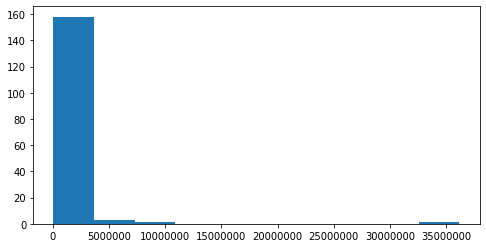

In [12]:
# your code here
# import package
import matplotlib.pyplot as plt

# calculate the image resolution
res = (df['Width'] * df['Height']).to_numpy()

# plot the histogram
plt.figure(figsize=(8,4))
plt.hist(res)
plt.ticklabel_format(style='plain')


__P2-P4. Distribution of Mean Hue, Saturation, Value__

Next plot histograms of mean hue, saturation, and value, and dislpay inline below

(array([54., 20., 23., 20., 14., 10.,  4., 10.,  4.,  4.]),
 array([0.03648942, 0.13115875, 0.22582808, 0.32049742, 0.41516675,
        0.50983608, 0.60450541, 0.69917474, 0.79384408, 0.88851341,
        0.98318274]),
 <a list of 10 Patch objects>)

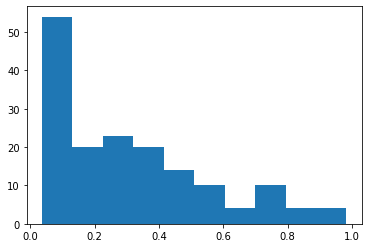

In [13]:
# your code for mean hue histogram
plt.hist(df['Hue'])

(array([ 7.,  7., 19., 21., 32., 27., 20., 14., 10.,  6.]),
 array([0.06539565, 0.15718603, 0.2489764 , 0.34076677, 0.43255714,
        0.52434751, 0.61613788, 0.70792826, 0.79971863, 0.891509  ,
        0.98329937]),
 <a list of 10 Patch objects>)

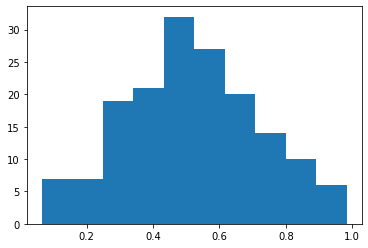

In [14]:
# your code for mean saturation histogram
plt.hist(df['Saturation'])

(array([ 3., 11.,  8., 17., 20., 17., 25., 25., 27., 10.]),
 array([0.04531424, 0.13773755, 0.23016086, 0.32258417, 0.41500748,
        0.50743079, 0.59985409, 0.6922774 , 0.78470071, 0.87712402,
        0.96954733]),
 <a list of 10 Patch objects>)

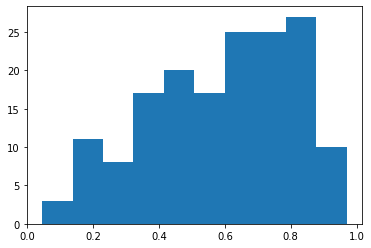

In [15]:
# your code for mean value histogram
plt.hist(df['Value'])

__P5. Scatterplot with matplotlib (mean value vs. mean hue)__

Now produce a simple scatter plot of mean value against mean hue.

(see example notebook on plotting)

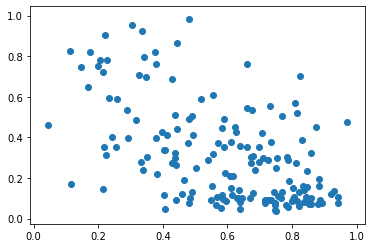

In [16]:
# your code for scatter plot of mean_value (X) against mean_hue (Y)
plt.scatter(df['Value'], df['Hue'])

#### P6-P7. Produce Large Bitmap Figures illustrating your results

(see example notebook on producing large tiled image figures: [../examples/large_figures.ipynb](../examples/large_figures.ipynb))

In [17]:
# from skimage import io
from PIL import Image
import matplotlib.pyplot as plt

##### Step 1: Generate thumbnails from full-resolution scraped images

Write a `make_thumbnail()` function that takes a filename, imagepath, and thumbnail path as arguments

In [18]:
# your code here
def make_thumbnail(FileName, ImagePath, ThumbPath):
    # read the image from path
    path = os.path.join(ImagePath, FileName)
    img = Image.open(path)
    
    # make thumbnail of image
    size = 128, 128
    img.thumbnail(size)
    save_path = os.path.join(ThumbPath, FileName)
    img.save(save_path)

Create a folder to store your thumbnails

In [19]:
# your code here
# initialize thumbnails directory path
THUMB_DIR = '../data/mark-rothko/thumbnails'

# make directory if the path not exists 
if not os.path.exists(THUMB_DIR):
    os.makedirs(THUMB_DIR)

Iterate over your Rothko paintings and write thumbnails to disk

In [20]:
# your code here
# iterate over Rothko's paintings
for image in os.listdir(IMAGE_DIR):
    # make thumbnail of images
    make_thumbnail(image, IMAGE_DIR, THUMB_DIR)

In [21]:
# check whether thumbnails successfully created
len(os.listdir(THUMB_DIR))

163

##### Step 2: Create large plots on an empty bitmap canvas, placing thumbnails based on feature coordinates.

Make a folder to save result (`../data/mark-rothko/results`)

In [22]:
# your code here
# initialize the result directory
RESULT_DIR = '../data/mark-rothko/results'

# check if the file path exists, if not then create the directory
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)

Plot mean value vs. mean hue with image thumbnails on large bitmap

In [23]:
# your code here
# create background image
GLOBAL_WIDTH = 4000
bg_color = (192, 192, 192)
figure_ValueHue = Image.new('RGB', (GLOBAL_WIDTH, GLOBAL_WIDTH), bg_color)

In [24]:
# extract the features from the dataframe
info = df[['File','Value', 'Hue']].to_numpy()

# iterate over the thumbnails
for i in range(len(info)):
    # get the thumbnail path
    img_path = THUMB_DIR+ '/' + info[:, 0][i]
    img = Image.open(img_path)
    # convert the coordinates
    coord = list((info[:, 1:][i])*GLOBAL_WIDTH)
    coord_int = [int(i) for i in coord]
    # paste the thumbnail on the thumbnail
    figure_ValueHue.paste(img, coord_int)

# save the bitmap
vh_path = RESULT_DIR + '/ValueHue.jpg'
figure_ValueHue.save(vh_path)

Produce a second plot: mean value vs mean saturation

In [25]:
# your code here
figure_ValueSat = Image.new('RGB', (GLOBAL_WIDTH, GLOBAL_WIDTH), bg_color)

# extract the features from the dataframe
info = df[['File','Value', 'Saturation']].to_numpy()

# iterate over the thumbnails
for i in range(len(info)):
    # get the thumbnail path
    img_path = THUMB_DIR+ '/' + info[:, 0][i]
    img = Image.open(img_path)
    # convert the coordinates
    coord = list(info[:, 1:][i])
    coord_int = [int(i*GLOBAL_WIDTH) for i in coord]
    # paste the thumbnail on the thumbnail
    figure_ValueSat.paste(img, coord_int)

# save the bitmap
vs_path = RESULT_DIR + '/ValueSat.jpg'
figure_ValueSat.save(vs_path)

Display the figures inline in this notebook

Text(0.5, 1.0, 'mean value Vs. mean hue')

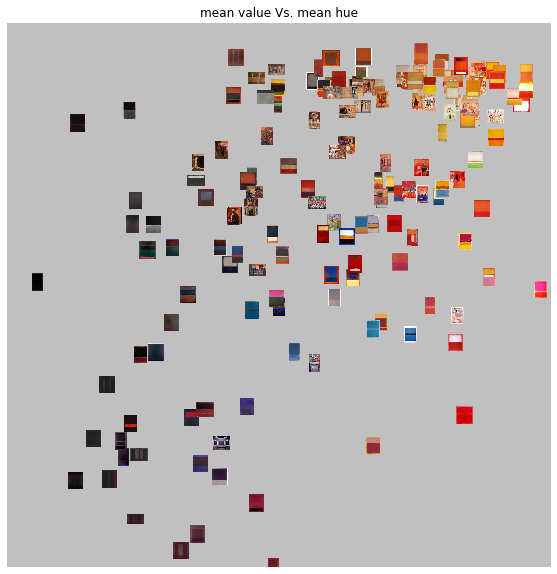

In [26]:
# your code here
# display the graph of mean value vs. mean hue
img = plt.imread(vh_path)
fig,ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)
ax.axis('off')
ax.set_title('mean value Vs. mean hue')

Text(0.5, 1.0, 'mean value Vs. mean saturation')

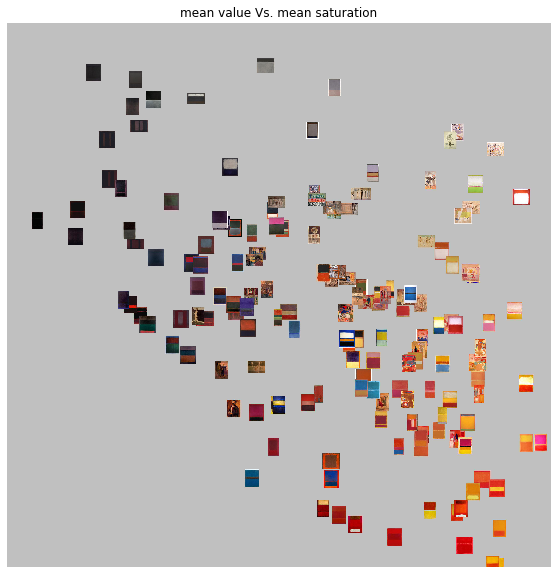

In [27]:
# display the graph of mean value vs. mean saturation
img = plt.imread(vs_path)
fig,ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)
ax.axis('off')
ax.set_title('mean value Vs. mean saturation')

## Part 2: Extension
(70 points total)

For this part, you will repeat the above image feature summary analysis (mean brightness, mean hue) using a dataset of your choice. Your data should have approximately n <= 100 images. Your output should be a similar tiled image as produced in the previous section, along with a short paragraph describing your results and why they are interesting.

 ### 2A. Scraping/downloading your new imagery
 (10 points)

In [28]:
# your code here
# get the page from WikiArt
url_query = ARTIST_URL.format(artist='friedel-dzubas')
artist_page = requests.get(url_query)

# raise error if there is request error
try:
    artist_page.raise_for_status()
except requests.exceptions.HTTPError as e:
    print("Error trying to retrieve {}".format(artist_page.url))
    raise e

# get the info stored on the page by BS4
soup = BeautifulSoup(artist_page.text, 'lxml')

# create the image storage directory
IMAGE_DIR = os.path.join(DATA_DIR, 'friedel-dzubas/images')
if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR)

In [29]:
painting_paths = []

# retreive all rows in painting-list
for li in soup.find_all('li', {'class': 'painting-list-text-row'}):

    # retrieve all links in the current row
    for link in li.find_all('a'):
        href = link.get('href')
        # store in dictionary
        painting_paths.append(href)

# check how many paintings retrieved for Friedel Dzubas
print(len(painting_paths))

85


In [30]:
# download all the paintings from Friedel Dzubas
for path in painting_paths:
    painting_path = PAINTING_URL.format(painting_path=path)
    # use the method created above
    download_and_save(painting_path)

In [31]:
# check how many paintings downloaded
len(os.listdir('../data/friedel-dzubas/images'))

85

### 2B. Calculating image features
(10 points)

Model your features on the above exercise, or incorporate other stats (variance, edge count, etc.)

In [32]:
# copy the code from example to calculate the image energy
def calcDGenergy(img):
    # from from https://stackoverflow.com/a/48974892

    #convert from uint8 to int64 to prevent overflow problems
    arr = np.array(img, dtype = int)

    #calculate squared difference ((x-1, y) - (x+1, y))^2 for each R, G and B pixel
    deltaX2 = np.square(np.roll(arr, -1, axis = 0) - np.roll(arr, 1, axis = 0))

    #same for y axis
    deltaY2 = np.square(np.roll(arr, -1, axis = 1) - np.roll(arr, 1, axis = 1))

    #add R, G and B values for each pixel, then add x- and y-shifted values
    dualEnergy = np.sum(deltaX2, axis = 2) + np.sum(deltaY2, axis = 2)
    return dualEnergy

In [33]:
# your code here
# read all images files
images = os.listdir(IMAGE_DIR)
arr = []

# iterate over Dzubas's paintings
for img in images:
    # read the image
    en_img = io.imread('../data/friedel-dzubas/images/'+img)
    # use the method above to calculate mean energy
    energy = calcDGenergy(en_img).mean()
    
    # use the method constructed above to calculate the basic stats
    arr.append([img]+calc_stats(img)+[energy])

# add to a dataframe
df_new = pd.DataFrame(arr, columns=['File', 'Width', 'Height', 'Hue', 'Saturation', 'Value','Energy'])

# save the dataframe into a csv file locally
df_new.to_csv(r'../data/friedel-dzubas.csv', index=False)

# show few lines in the df
df_new.head()

,File,Width,Height,Hue,Saturation,Value,Energy
0,agmont-1981.jpg,570,196,0.406459,0.279516,0.814126,579.208969
1,antigua-1971.jpg,640,249,0.414440,0.145947,0.714043,153.981965
2,aruba-1969.jpg,937,147,0.164489,0.203547,0.780530,486.671168
3,ascona-1976.jpg,570,568,0.265049,0.462977,0.787463,504.053181
4,aurora-1977.jpg,570,570,0.325759,0.490251,0.504855,1487.682942


### 2C. Produce and Display output plots (results)
(25 points)

Produce high resolution results images, and display them inline in the notebook

In [34]:
# your code here
# make the path for thumbnails
THUMB_DIR = '../data/friedel-dzubas/thumbnails'

# create directory if not exists
if not os.path.exists(THUMB_DIR):
    os.makedirs(THUMB_DIR)

# iterate over Dzubas' paintings
for image in os.listdir(IMAGE_DIR):
    # make thumbnail of paintings
    make_thumbnail(image, IMAGE_DIR, THUMB_DIR)

# check whether thumbnails successfully created
len(os.listdir(THUMB_DIR))

85

Plot mean value vs. mean hue with thumbnails on large bitmap

In [35]:
# initialize the result directory
RESULT_DIR = '../data/friedel-dzubas/results'

# check if the file path exists, if not then create the directory
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)

Text(0.5, 1.0, 'mean value Vs. mean hue')

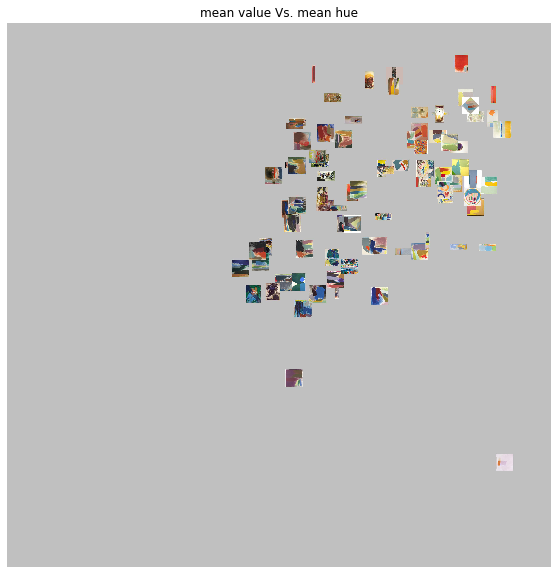

In [41]:
# create background image
GLOBAL_WIDTH = 4000
bg_color = (192, 192, 192)
figure_ValueHue = Image.new('RGB', (GLOBAL_WIDTH, GLOBAL_WIDTH), bg_color)

# extract the features from the dataframe
info = df_new[['File','Value', 'Hue']].to_numpy()

# iterate over the thumbnails
for i in range(len(info)):
    # get the thumbnail path
    img_path = THUMB_DIR+ '/' + info[:, 0][i]
    img = Image.open(img_path)
    # convert the coordinates
    coord = list((info[:, 1:][i])*GLOBAL_WIDTH)
    coord_int = [int(i) for i in coord]
    # paste the thumbnail on the thumbnail
    figure_ValueHue.paste(img, coord_int)

# save the bitmap
vh_path = RESULT_DIR + '/ValueHue.jpg'
figure_ValueHue.save(vh_path)

# display the graph of mean value vs. mean hue
img = plt.imread(vh_path)
fig,ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)
ax.axis('off')
ax.set_title('mean value Vs. mean hue')

Plot mean value vs. mean saturation with thumbnails on large bitmap

Text(0.5, 1.0, 'mean value Vs. mean saturation')

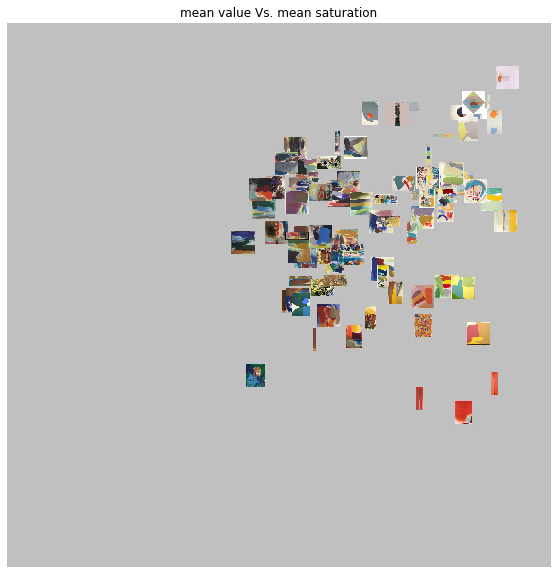

In [37]:
figure_ValueSat = Image.new('RGB', (GLOBAL_WIDTH, GLOBAL_WIDTH), bg_color)

# extract the features from the dataframe
info = df_new[['File','Value', 'Saturation']].to_numpy()

# iterate over the thumbnails
for i in range(len(info)):
    # get the thumbnail path
    img_path = THUMB_DIR+ '/' + info[:, 0][i]
    img = Image.open(img_path)
    # convert the coordinates
    coord = list(info[:, 1:][i])
    coord_int = [int(i*GLOBAL_WIDTH) for i in coord]
    # paste the thumbnail on the thumbnail
    figure_ValueSat.paste(img, coord_int)

# save the bitmap
vs_path = RESULT_DIR + '/ValueSat.jpg'
figure_ValueSat.save(vs_path)

# display the graph of mean value vs. mean saturation
img = plt.imread(vs_path)
fig,ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)
ax.axis('off')
ax.set_title('mean value Vs. mean saturation')

Plot mean value vs. mean energy with thumbnails on large bitmap

In [38]:
df_new['Energy'].max()

6478.952716638675

Text(0.5, 1.0, 'mean value Vs. mean energy')

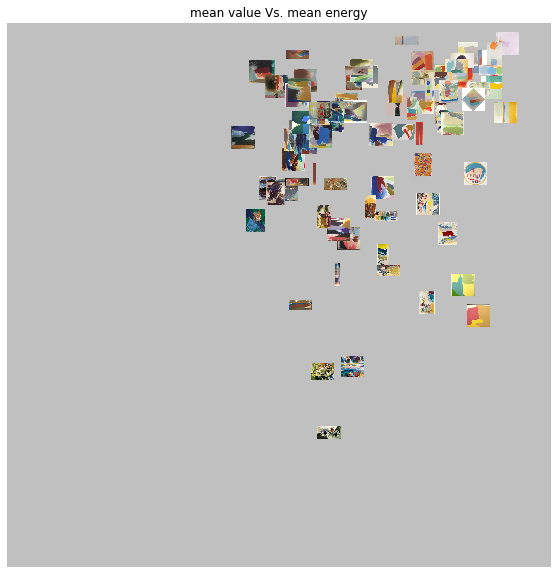

In [39]:
figure_ValueEne = Image.new('RGB', (GLOBAL_WIDTH, GLOBAL_WIDTH), bg_color)

# extract the features from the dataframe
info = df_new[['File','Value', 'Energy']].to_numpy()

# get the max value in energy
en_max = df_new['Energy'].max()

# iterate over the thumbnails
for i in range(len(info)):
    # get the thumbnail path
    img_path = THUMB_DIR+ '/' + info[:, 0][i]
    img = Image.open(img_path)
    # convert the coordinates
    coord = list(info[:, 1:][i])
    coord_new = []
    coord_new.append(int(coord[0]*GLOBAL_WIDTH))
    coord_new.append(int(coord[1] / en_max * GLOBAL_WIDTH))
    
    # paste the thumbnail on the thumbnail
    figure_ValueEne.paste(img, coord_new)
    
# save the bitmap
ve_path = RESULT_DIR + '/ValueEne.jpg'
figure_ValueEne.save(ve_path)

# display the graph of mean value vs. mean energy
img = plt.imread(ve_path)
fig,ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)
ax.axis('off')
ax.set_title('mean value Vs. mean energy')

The correlation table for the feature table:

In [40]:
df_new.corr()

,Width,Height,Hue,Saturation,Value,Energy
Width,1.000000,-0.074890,-0.063150,-0.348273,-0.083000,-0.041672
Height,-0.074890,1.000000,-0.073286,0.027660,0.012249,-0.092705
Hue,-0.063150,-0.073286,1.000000,-0.205177,-0.305106,0.085050
Saturation,-0.348273,0.027660,-0.205177,1.000000,-0.201572,0.219912
Value,-0.083000,0.012249,-0.305106,-0.201572,1.000000,-0.236812
Energy,-0.041672,-0.092705,0.085050,0.219912,-0.236812,1.000000


### 2D. Describe your Results
(25 points)

Replace the contents of the markdown cell below with a two paragraph summary of your extension work.

The dataset I used in extension work is from the WikiArt website: https://www.wikiart.org/en/friedel-dzubas. These paintings were created by a German American abstract artist, Friedel Dzubas. According to the brief introduction shown on the WikiArt website, Dzubas was born in Berlin in 1915 and later fled to New York in 1939. He was active in the Abstract Expressionist movement in the mid-century United States. At the first glance of Dzubas' paintings, I noticed that the majority of them are made up of several simple shapes, such as wide lines, squares, and irregular rectangles. However, his paintings are distinct from the geometric abstractionism which was popular during the early 20 century. In general, the style of Dzubas’ works is expressive, incompact, and painterly. Since these paintings are distinctive in the color and shape elements, it will be interesting to perform the image feature summary analysis on them. The paintings I gathered from WikiArt are 85 in total. I first requested the website page by using the url and used BeautifulSoup to extract the html information stored on this page. Then based on the html form, I obtained a list of website links of Dzubas’ paintings. For all of the Dzubas’ paintings, I have downloaded and saved them in local disk though the list of links. 

After scraping out the useful data (85 paintings), I extracted numbers of features from these images: height, width, hue, saturation, value (brightness), and image energy. Here the energy feature represents the mean of energy of each pixel on the image by implementing the dual gradient energy function which provided in the example. The higher the energy (on each pixel), the color gradient changes more rapidly. For example, the boundary between each “color block” on the painting will have higher energy. In the next step, I have plotted 3 scatter plots on the large bitmaps by using the thumbnails of paintings. The first plot is “mean value vs. mean hue”, which demonstrates the correlation between the value and hue; and the plot shows that the higher the mean value, the lower the mean hue will be in the Dzubas’ paintings (the bitmap is inverted since the Image.paste function starts pasting coordinate on the upper left corner). The second plot is “mean value vs. mean saturation” which approximately shows that the higher mean value, the lower the mean saturation except for some outliers. Finally, the third plot is “mean value vs. mean energy” which indicates the higher mean value, the lower mean energy. All of these features pairs bitmap slightly show the negative correlation between them, which also proved in the correlation table. In comparison to Rothko’s paintings, Dzubas’ paintings have the same direction of correlation when analyzing the mean value and mean hue features; however, the opposite direction when analyzing the mean value and mean saturation features. It is interesting to compare the paintings between these two painters, Rothko and Dzubas since both of them are abstract painters and active in the same time period. Although the genre of their paintings were abstract, Rothko was more interested in abstract expressionism while Dzubas was known for lyrical abstract. These similarities and differences might be the potential factors to explain the different trend in feature correlations. Based on the result from extension work, I would like to continue analyzing paintings, especially toward those abstract artworks in the 20th century.


## References

### Additional Cultural Archives:
* [The Getty](https://www.getty.edu/art/collection/) (The J. Paul Getty Museum, LA)
* [The Met Collection](https://www.metmuseum.org/art/collection) (Metropolitan Museum of Art, NYC)
* MoMA (Museum of Modern Art) online collection: [https://www.moma.org/collection/](https://www.moma.org/collection/)
  * Our evolving collection contains almost 200,000 works of modern and contemporary art. More than 85,000 works are currently available online.
* Metropolitan Museum of Art collection on Archive.org: [https://archive.org/details/metropolitanmuseumofart-gallery](https://archive.org/details/metropolitanmuseumofart-gallery?&sort=-downloads&page=2)
* [MoMA exhibition images](https://www.moma.org/collection/) (showing how paintings were installed)
   * read about it here [You Can Now Explore Every MoMA Exhibit Since 1929 for Free Online](https://mymodernmet.com/museum-of-modern-art-exhibition-history/?fbclid=IwAR3LkAPAXmDJ4C9zJn6ujfmhh2zNp6GJL9ysHTMgoKPS5ARp8jx3EklaIUk)
* [Paul Klee notebooks](http://www.kleegestaltungslehre.zpk.org/ee/ZPK/BF/2012/01/01/001/)
  - read about it [here](http://www.openculture.com/2016/03/3900-pages-of-paul-klees-personal-notebooks-are-now-online.html?fbclid=IwAR1_dGLxqy0YAiGuxJD2uTVUiyS0sSJuoX8iKuy_k01LWHbAYcbprNp4hd4)
